## Introduction to Microstructure Thermodynamics
## Vahid Attari, attari.v@tamu.edu
### Department of Materials Sceicene and Engineering
### Texas A&M University
### Phase-field Tutorial 

## Outline
### - Using PyCalphad for calculation of phase diagrams (Ag-Cu alloy)
### - Using PyCalphad for getting free energy of phases 
### - Free energy curves
### - Fitting energy coefficients for use in phase-field code
### - Phase-field method
### - Setting alloy composition for modeling
### - Running phase-field code
### - Getting microstructure images

# Phase-field method:

### For this problem, I used the simplest possible phase-field model, which is for an isothermal binary dual-phase alloy with one solid phase ($c = c_\alpha$) and other solid phase ($c = c_\beta$) phase. The free energy of this system is defined by:

<h1><center>                
$F^{total} = \int_V \big[f^{bulk} + f^{interface} \big] dV$</center></h1>

### - where $f^{bulk}$ is bulk free energy of the material, and $f^{interface}$ is the energy associated with interfaces that control the amount of mass transfer through the interaces. The evolution of concentraion (phase-field order parameter) in alloy is given by:

<h1><center>                
$\frac{\partial c}{\partial t}= \nabla . \bigg\{ M \nabla \big( \dfrac{\partial f_{bulk}}{\partial c} - \epsilon^2 \nabla^2 c \big) \bigg \}  $
</center></h1>

### - which is called Cahn-Hilliard equation. In this equation $M$ is interface mobility and $\epsilon$ is gradient energy coefficient.


In [1]:
%matplotlib inline

### python utility
import os
import matplotlib.pyplot as plt
import numpy as np

### PyCALPHAD
from pycalphad import binplot
from pycalphad import Database, calculate, variables as v
from pycalphad.plot.utils import phase_legend
np.seterr(divide='ignore', invalid='ignore')

### Curve fitting
from scipy.optimize import curve_fit, fsolve, newton
from scipy.interpolate import RectBivariateSpline

In [2]:
### Load a database:
db = Database('nanoAgCu.tdb') # 1. Al-Li-Mg.tdb 2. Al_Li_Zn_Guo

#print(db)
#print(db.__dict__)

['AG', 'VA', '/-', 'CU']
['AG', 'VA', 'CU']


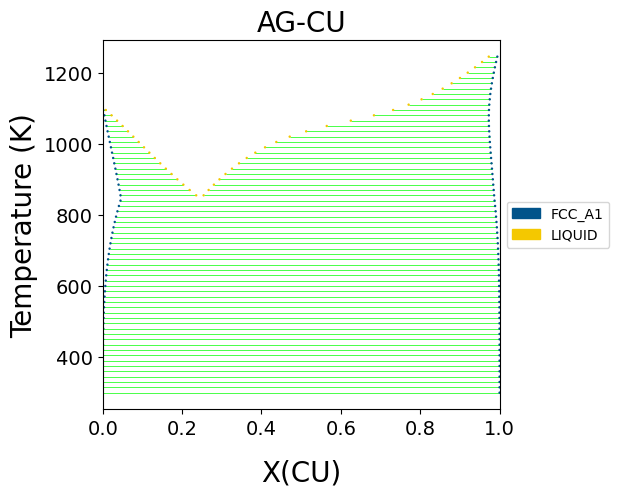

In [3]:
print(list(db.elements))

# Define the components
comps = list(db.elements)     
comps.remove('/-')
print(comps)

# Get all possible phases programmatically
phases = db.phases.keys()

# Plot the phase diagram, if no axes are supplied, a new figure with axes will be created automatically
binplot(db, comps, phases, {v.N: 1, v.P:101325, v.T: (300, 2000, 15), v.X('CU'):(0, 1, 0.02)})

plt.show()

['AG', 'VA', 'CU']


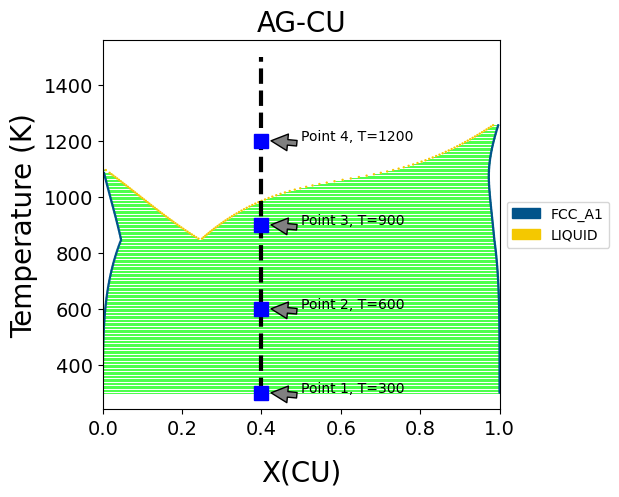

In [4]:
comps = list(db.elements)     #['AL', 'Zn', 'VA']
comps.remove('/-')
print(comps)

# Get all possible phases programmatically
phases = db.phases.keys()

# Plot the phase diagram, if no axes are supplied, a new figure with axes will be created automatically
binplot(db, comps, phases, {v.N: 1, v.P:101325, v.T: (300, 1500, 5), v.X('CU'):(0, 1, 0.02)})

temp = [300,600,900,1200]

k = 1
for T in temp:
    # line
    if k==1:
        plt.plot([0.4, 0.4], [300, 1500], color='black', linewidth=3, linestyle='--')
    plt.plot([0.4], [T], 's', markersize=10, color='blue')
    plt.annotate('Point '+str(k)+', T='+str(T),xy = (0.42,T), xytext=(0.5, T), arrowprops=dict(facecolor='gray', shrink=0.05))
    k = k + 1

plt.show()

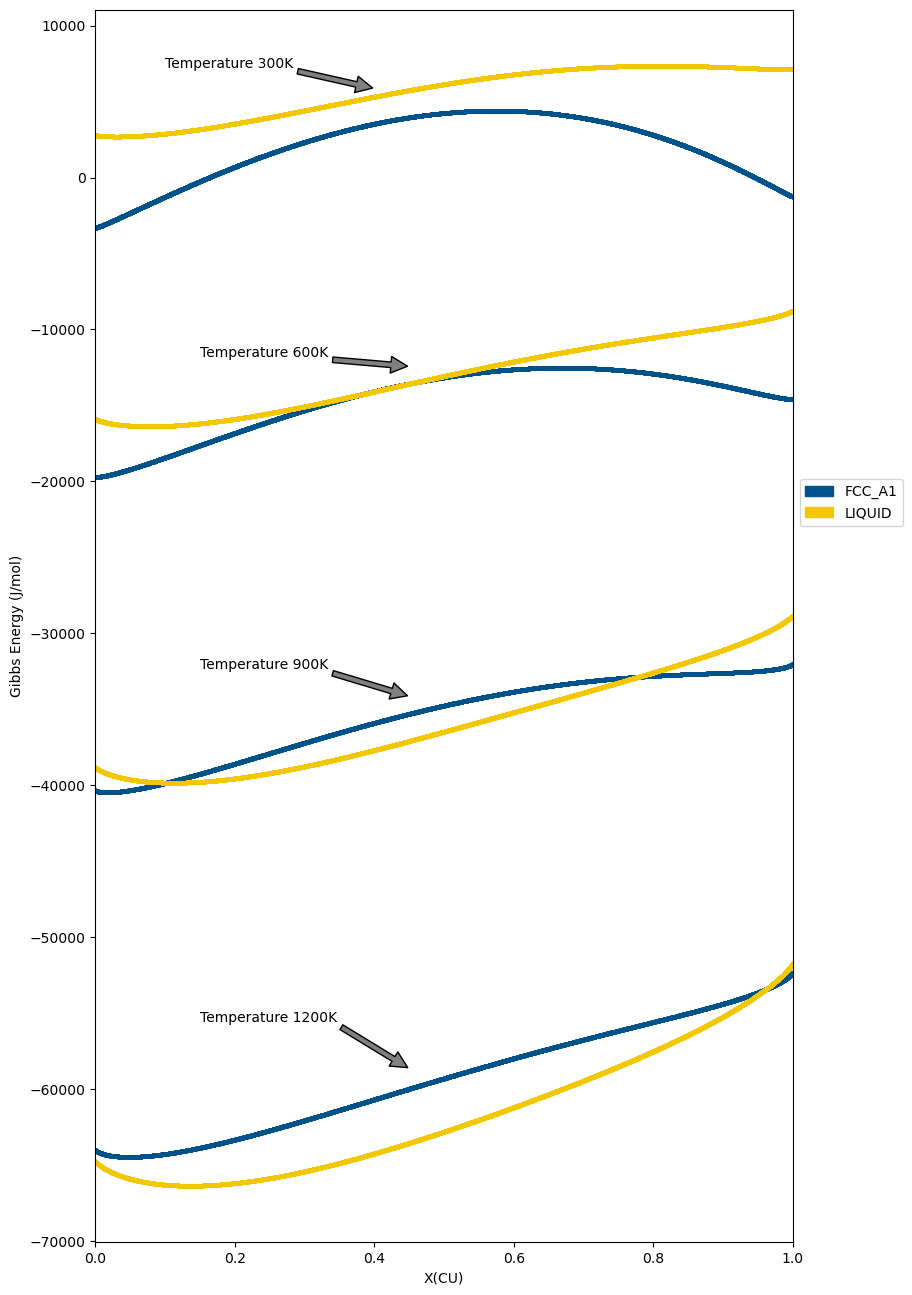

In [5]:
phases = list(db.phases.keys() )

# Get the colors that map phase names to colors in the legend
legend_handles, colorlist = phase_legend(sorted(phases))

fig = plt.figure(figsize=(9,16))
ax = fig.gca()

# Loop over phases, calculate the Gibbs energy, and scatter plot GM vs. X(CU)
k = 0
for T in temp:

    for phase_name in phases:
        result = calculate(db, comps, phase_name, P=101325, T=T, output='GM' )
        ax.scatter(result.X.sel(component='CU'), result.GM, marker='o', s=5, c=colorlist[phase_name] )

    # Format the plotgege
    #ax.set_title('Free energy curves at '+str(T)+'K' )
    if np.max(result.GM.squeeze()) > 0:
        ax.annotate('Temperature '+str(T)+'K',xy = (0.4,np.average(result.GM.squeeze())*1.05), xytext = (0.1,np.average(result.GM.squeeze())*1.3), arrowprops=dict(facecolor='gray', shrink=0.02))
    else:
        ax.annotate('Temperature '+str(T)+'K',xy = (0.45,np.average(result.GM.squeeze())*0.95), xytext = (0.15,np.average(result.GM.squeeze())*0.9), arrowprops=dict(facecolor='gray', shrink=0.02))

    ax.set_xlabel('X(CU)')
    ax.set_ylabel('Gibbs Energy (J/mol)')
    ax.set_xlim((0, 1))
    ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
    k = k+1

    ## common tangent line
    #ax.plot([0, 0.5], [-12000, -30000], color='black', linewidth=3, linestyle='--')

plt.show()

## Polynomial coefficients from curve fitting to CALPHAD at required temperature (K)

## $f(x) = ax^{10} + bx^9 + cx^8 + dx^7 + ex^6 +fx^5 + gx^4 + hx^3 + ix^2 + jx + k  $

## $df/dx = ax^{9} + bx^8 + cx^7 + dx^6 + ex^5 +fx^4 + gx^3 + hx^2 + ix + j  $


/Users/attari.v/opt/anaconda3/envs/pycalphad-env/lib/python3.8/site-packages/pycalphad/codegen/callables.py:94: UserWarning: State variables in `build_callables` are not {N, P, T}, but {T, N}. This can lead to incorrectly calculated values if the state variables used to call the generated functions do not match the state variables used to create them. State variables can be added with the `additional_statevars` argument.
  warnings.warn("State variables in `build_callables` are not {{N, P, T}}, but {}. This can lead to incorrectly "


900


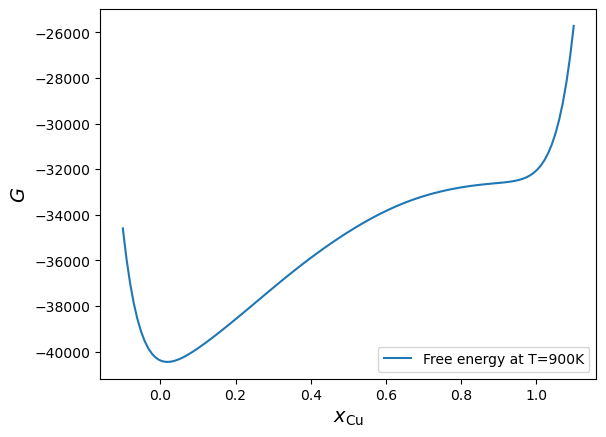

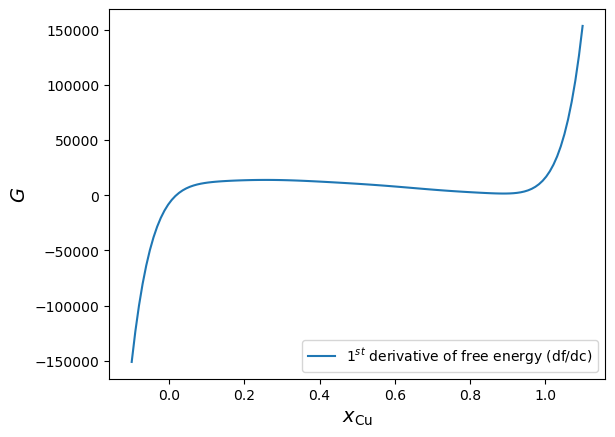

Fir Coef.:
[ 5.02463498e+06 -2.51325171e+07  5.42511666e+07 -6.61771148e+07
  5.02180708e+07 -2.46336377e+07  7.89734766e+06 -1.66518405e+06
  2.32651413e+05 -7.09433173e+03 -4.03943318e+04]


In [6]:
calC = [0.]

temp1 = [900]

for T in temp1:
    calC = [0.]

    # Generate free energy curves with PyCalphad
    try:
        with open('nanoAgCu.tdb') as file:
            def energy(x, a, b, c, d, e, f, g, h, i, j, k):
                return a*x**10 + b*x**9 + c*x**8 + d*x**7 + e*x**6 + \
                       f*x**5 + g*x**4 + h*x**3 + i*x**2 + j*x + k
            def chempot(x, a, b, c, d, e, f, g, h, i, j):
                return 10*a*x**9 + 9*b*x**8 + 8*c*x**7 + 7*d*x**6 + 6*e*x**5 + \
                        5*f*x**4 + 4*g*x**3 + 3*h*x**2 + 2*i*x + j

            # Import the database
            CuAgCalphadDatabase = Database('nanoAgCu.tdb')
            Gs = calculate(CuAgCalphadDatabase, comps, 'FCC_A1', T=T, output='GM')
            xs = np.ravel(Gs.X.sel(component='CU'))
            ys = np.ravel(Gs.GM)
            calC, pcov1 = curve_fit(energy, xs, ys)

    except IOError as e:
        print("CALPHAD database file not found, assuming defaults.")


    # bulk free energy curves
    def fS(c_):
        return   calC[0]*c_**10 + calC[1]*c_**9 + calC[2]*c_**8 + calC[3]*c_**7 \
               + calC[4]*c_**6  + calC[5]*c_**5 + calC[6]*c_**4 + calC[7]*c_**3 \
               + calC[8]*c_**2  + calC[9]*c_    + calC[10]

    # first derivatives
    def dfSdc(c_):
        return  10.0*calC[0]*c_**9 + 9.0*calC[1]*c_**8 + 8.0*calC[2]*c_**7 \
               + 7.0*calC[3]*c_**6 + 6.0*calC[4]*c_**5 + 5.0*calC[5]*c_**4 \
               + 4.0*calC[6]*c_**3 + 3.0*calC[7]*c_**2 + 2.0*calC[8]*c_ + calC[9];

    print(T)
    plt.figure
    w = np.linspace(-0.1,1.1,125)
    plt.plot(w, fS(w), label=('Free energy at T='+str(T)+'K'))
    plt.xlabel('$x_\mathrm{Cu}$',fontsize=14)
    plt.ylabel('$G$',fontsize=14)
    plt.legend(loc=4)
    plt.show()
    
    plt.figure
    plt.gca()
    plt.plot(w, dfSdc(w), label=('1$^{st}$ derivative of free energy (df/dc)'))
    plt.xlabel('$x_\mathrm{Cu}$',fontsize=14)
    plt.ylabel('$G$',fontsize=14)
    plt.legend(loc=4)
    plt.show()

    print("Fir Coef.:")
    print(calC)

## Save the Fit Coef. to txt files

In [7]:
if (os.path.exists('phase-field_code/input/')):
    print('Writing file...')
else:
    os.mkdir('phase-field_code/input/')
    
# open file in write mode
with open(r'phase-field_code/input/poten'+str(T)+'.txt', 'w') as fp:
    for item in calC:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Writing file...
Done


## Define Alloy Composition

## $c(x,y,t_0= 0) = c_0 + A\zeta$

### - where $c_0$ is avergae alloy composition, A is noise amplitude, and $\zeta$ is random noise between [-1,1].

In [8]:
## Choose and save alloy composition 

alloy_composition = [0.5]

# open file in write mode
with open(r'phase-field_code/input/mts_pars'+str(T)+'.txt', 'w') as fp:
    for item in alloy_composition:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [9]:
print(os.getcwd() )

os.chdir('phase-field_code/src')

/Users/attari.v/Documents/PROJECTS/VOx_study/Phase-field_PyCalphad Tutorial


## Run the phase-field code

In [10]:
import subprocess

result = subprocess.run(['make', 'clean'])
if result == 0:
    print('error in make clean...')

print(os.getcwd() )
make_process = subprocess.run("make", stderr=subprocess.STDOUT)
if make_process == 0:
    print('error in make ...')

make_process = subprocess.run("./main", stderr=subprocess.STDOUT)
if make_process == 0:
    print('error in executation ...')


rm -f *.o *.mod *.smod *.anc *.png main *.out fort*
/Users/attari.v/Documents/PROJECTS/VOx_study/Phase-field_PyCalphad Tutorial/Phase-field_code/src
gfortran   -c   pfm_CH_2D_AgCu.f90
gfortran   -c  -o pfm_CH_2D_AgCu.o pfm_CH_2D_AgCu.f90
gfortran  -o main pfm_CH_2D_AgCu.o
rm pfm_CH_2D_AgCu.anc
 DT1       =   49600.1016    
 Nx        =         128
 Lx        =   1.9999999949504854E-006
 DX        =   1.5748031456303034E-008
 DT        =   9.9999999600419720E-013

 Alloy Comp=  0.500000000    
 Noise Ampl=   1.99999996E-02

 EPSILON_SL=   3.16227761E-06
 sigma_SL  =   7.45356025E-04
 Delta_SL  =   3.16227755E-09

rm: ../parameters: No such file or directory
rm: *.dat: No such file or directory
rm: *.plt: No such file or directory
 ../microstructure/phi_000001.plt                                                
 ******Calculating...******
 IPC=           1 Time=   0.00000000     itimes=           1
 phi_min=  0.490000099     phi_max=  0.509997904    
 PHITOT=   8190.93799    
 chem_pot_m

In [11]:
os.getcwd()

'/Users/attari.v/Documents/PROJECTS/VOx_study/Phase-field_PyCalphad Tutorial/Phase-field_code/src'

## Read and visualize microstructure files...

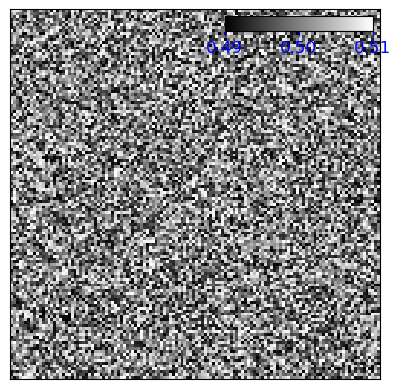

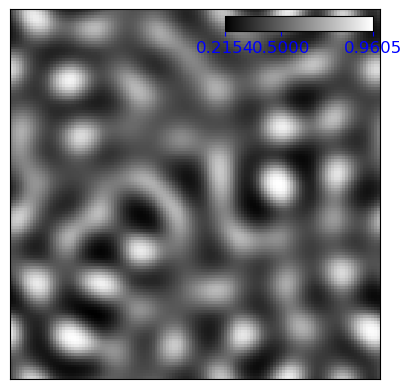

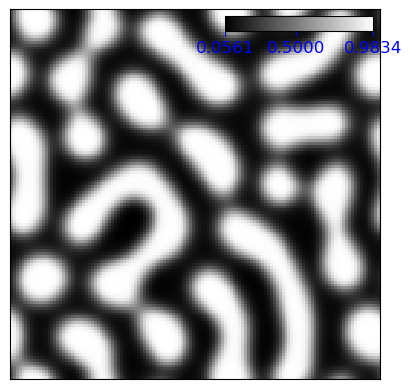

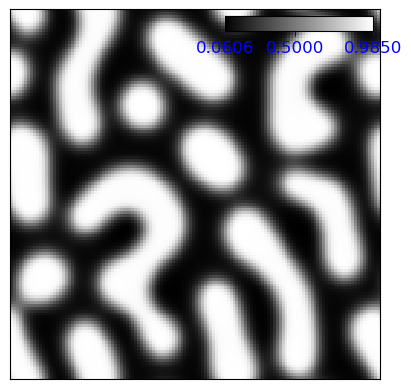

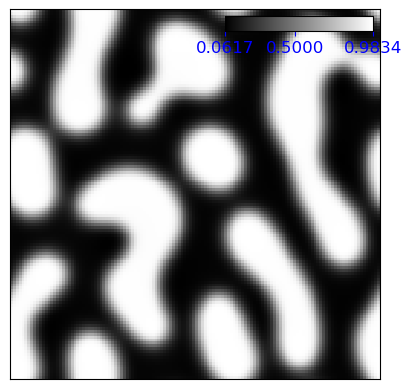

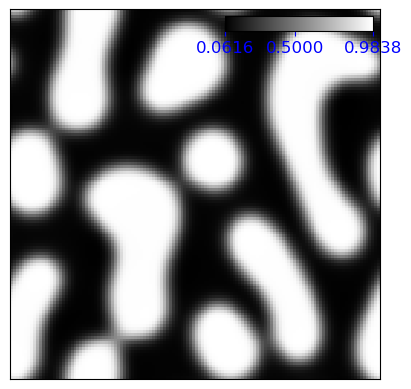

In [15]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import warnings

warnings.filterwarnings("ignore")

params = {"text.color" : "black"}
plt.rcParams.update(params)

def read_mic_file(filename):
    file_obj = open(filename,'r')
    zone_dict = {}
    array_list = []
    for line in file_obj:
        if 'variables' in line:
            re_finds_obj = re.findall(r'["](.*?)["]',line)
            headers = [find for find in re_finds_obj]
        elif 'ZONE' in line:
            # pass
            re_finds_obj = re.findall(r'[I][=][\s]*[0-9]+',line)
            I_val = int(re_finds_obj[0].split('=')[1].strip())
            J_val = int(re_finds_obj[0].split('=')[1].strip())
            zone_dict['I'] = I_val
            zone_dict['J'] = J_val
        elif line:
            line = line.replace('D','E')
            fix_E_points = re.findall('[\d][-][\d]',line)
            for E_point in fix_E_points:
                new_E_point = E_point.replace('-','E-')
                line = line.replace(E_point,new_E_point)
            
            line = np.fromstring(line.strip('[]'), dtype=float, sep = ' ')
            
            array_list.append(line)
        else:
            pass

    file_obj.close()
    df_out = pd.DataFrame(array_list,columns=headers)
    return df_out, zone_dict

#########

filenames = ['../microstructure/phi_000001.plt','../microstructure/phi_010000.plt','../microstructure/phi_020000.plt', \
             '../microstructure/phi_030000.plt','../microstructure/phi_040000.plt','../microstructure/phi_050000.plt']

for fl in filenames:
    ## plot 2 --- phase-field order parameter
    df2, zd = read_mic_file(fl)

    a   = df2.PHI.values
    phi = np.reshape(a,[zd['J'],zd['I']])
    phi = np.transpose(phi)
    phi = np.flip(phi)

    fig3, ax3 = plt.subplots()

    axins1 = inset_axes(ax3,
                        width="40%",  # width = 50% of parent_bbox width
                        height="4%",  # height : 5%
                        loc='upper right')

    im1 = ax3.imshow(phi, cmap='binary_r', interpolation='nearest')
    ax3.set(xticks=[], yticks=[])
    fig3.colorbar(im1, cax=axins1, orientation="horizontal", ticks=[np.min(phi), 0.5, np.max(phi)])
    axins1.tick_params(labelsize=12) 
    axins1.tick_params(colors='blue') 
    axins1.tick_params(grid_color='white')

In [16]:
## Let's choose a different alloy composition

In [17]:
## Choose and save alloy composition 

alloy_composition = [0.4]

fl_path = os.path.join(os.getcwd(),'../input/mts_pars'+str(T)+'.txt')
print(fl_path)

# open file in write mode
with open(fl_path, 'w') as fp:
    for item in alloy_composition:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
    
result = subprocess.run(['make', 'clean'])
if result == 0:
    print('error in make clean...')

print(os.getcwd() )
make_process = subprocess.run("make", stderr=subprocess.STDOUT)
if make_process == 0:
    print('error in make ...')

make_process = subprocess.run("./main", stderr=subprocess.STDOUT)
if make_process == 0:
    print('error in executation ...')
    

/Users/attari.v/Documents/PROJECTS/VOx_study/Phase-field_PyCalphad Tutorial/Phase-field_code/src/../input/mts_pars900.txt
Done
rm -f *.o *.mod *.smod *.anc *.png main *.out fort*
/Users/attari.v/Documents/PROJECTS/VOx_study/Phase-field_PyCalphad Tutorial/Phase-field_code/src
gfortran   -c   pfm_CH_2D_AgCu.f90
gfortran   -c  -o pfm_CH_2D_AgCu.o pfm_CH_2D_AgCu.f90
gfortran  -o main pfm_CH_2D_AgCu.o
rm pfm_CH_2D_AgCu.anc
 DT1       =   49600.1016    
 Nx        =         128
 Lx        =   1.9999999949504854E-006
 DX        =   1.5748031456303034E-008
 DT        =   9.9999999600419720E-013

 Alloy Comp=  0.400000006    
 Noise Ampl=   1.99999996E-02

 EPSILON_SL=   3.16227761E-06
 sigma_SL  =   7.45356025E-04
 Delta_SL  =   3.16227755E-09

rm: ../parameters: No such file or directory
rm: *.dat: No such file or directory
rm: *.plt: No such file or directory
 ../microstructure/phi_000001.plt                                                
 ******Calculating...******
 IPC=           1 Time= 

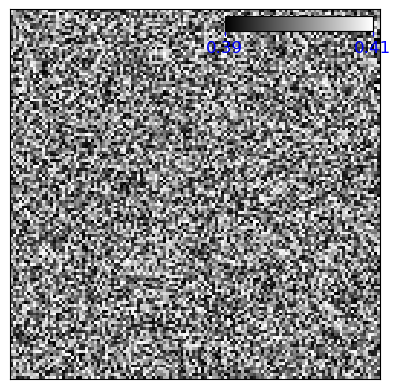

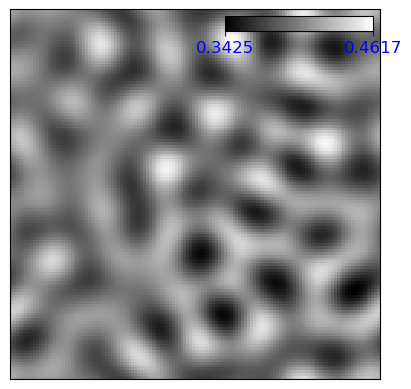

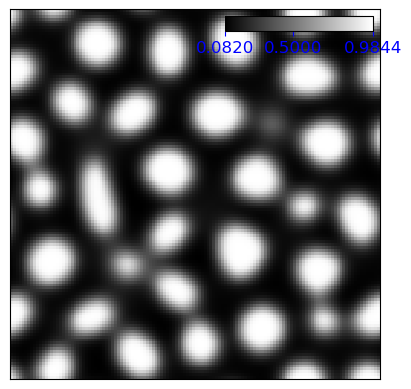

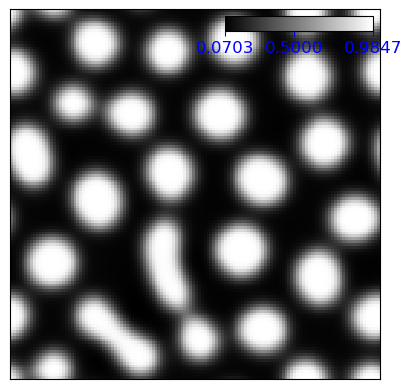

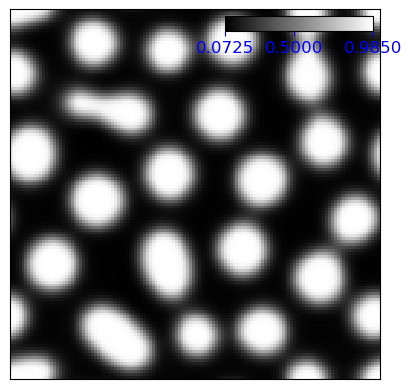

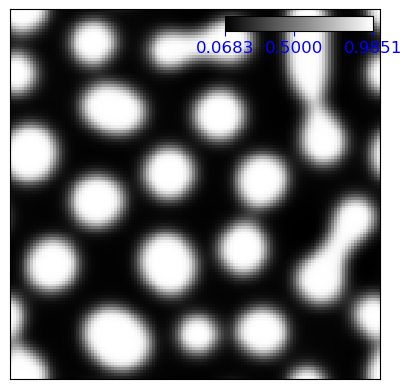

In [18]:
#########

filenames = ['../microstructure/phi_000001.plt','../microstructure/phi_010000.plt','../microstructure/phi_020000.plt', \
             '../microstructure/phi_030000.plt','../microstructure/phi_040000.plt','../microstructure/phi_050000.plt']

for fl in filenames:
    ## plot 2 --- phase-field order parameter
    df2, zd = read_mic_file(fl)

    a   = df2.PHI.values
    phi = np.reshape(a,[zd['J'],zd['I']])
    phi = np.transpose(phi)
    phi = np.flip(phi)

    fig3, ax3 = plt.subplots()

    axins1 = inset_axes(ax3,
                        width="40%",  # width = 50% of parent_bbox width
                        height="4%",  # height : 5%
                        loc='upper right')

    im1 = ax3.imshow(phi, cmap='binary_r', interpolation='nearest')
    ax3.set(xticks=[], yticks=[])
    fig3.colorbar(im1, cax=axins1, orientation="horizontal", ticks=[np.min(phi), 0.5, np.max(phi)])
    axins1.tick_params(labelsize=12) 
    axins1.tick_params(colors='blue') 
    axins1.tick_params(grid_color='white')